In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Import Libararies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

All libraries imported successfully


# Load Data Files

## Descriptions About DataSet

In [3]:

d1 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
d2 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv") 
d3 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
d4 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
d5 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")


d6 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
d7 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv") 
d8 = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")

print ("All Data Uplaoded")



All Data Uplaoded


In [4]:
dataframes = [d1, d2, d3, d4, d5, d6, d7, d8]
for df in dataframes:
    print(df.shape)
    print(df.head())# first five rows
    print(df.info()) #description
    print(df.describe())# analysis
    print(df.isnull().sum())# missing value
    print(df.duplicated().sum()) # total dup. values

(214046, 3)
  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58
3      book_00001  2023-01-16              44
4      book_00001  2023-01-18              12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB
None
       audience_count
count   214046.000000
mean        41.616568
std         32.834918
min          2.000000
25%         18.000000
50%         34.000000
75%         58.000000
max       1350.000000
book_theater_id    0
show_date          0
audience_count     0
dtype: int64
10
(829, 5)
  book_theater_id theater_type 

# Date time Columns conversions

In [5]:
d1['show_date'] = pd.to_datetime(d1['show_date'])
d4['show_date'] = pd.to_datetime(d4['show_date'])
d7['show_datetime'] = pd.to_datetime(d7['show_datetime'])
d7['booking_datetime'] = pd.to_datetime(d7['booking_datetime'])
d3['show_datetime'] = pd.to_datetime(d3['show_datetime'])
d3['booking_datetime'] = pd.to_datetime(d3['booking_datetime'])
print("Conversion Done")

Conversion Done


# EDA(Exploratory Data Analysis)

In [6]:
print("SIMPLE STATISTICS - KEY NUMBERS")
print("AUDIENCE COUNT:")
print(f"   Average per day:  {d1['audience_count'].mean()} people")
print(f"   Minimum:          {d1['audience_count'].min()} people")
print(f"   Maximum:          {d1['audience_count'].max()} people")
print(f"   Typical (median): {d1['audience_count'].median()} people")

print("THEATERS:")
print(f"   Total theaters:   {d1['book_theater_id'].nunique()}")
print(f"   Total records:    {len(d1):,}")

SIMPLE STATISTICS - KEY NUMBERS
AUDIENCE COUNT:
   Average per day:  41.61656840118479 people
   Minimum:          2 people
   Maximum:          1350 people
   Typical (median): 34.0 people
THEATERS:
   Total theaters:   826
   Total records:    214,046


In [7]:
# Data Types Analysis
print("\nBooknow Visits (d1):")
print(d1.dtypes)
print("\nBooknow Theaters (d2):")
print(d2.dtypes)
print("\nDate Info (d4):")
print(d4.dtypes)


Booknow Visits (d1):
book_theater_id            object
show_date          datetime64[ns]
audience_count              int64
dtype: object

Booknow Theaters (d2):
book_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object

Date Info (d4):
show_date      datetime64[ns]
day_of_week            object
dtype: object


In [8]:
# Statistical Summary
print("\nAudience Count Statistics:")
print(d1['audience_count'].describe())
print(f"\nTotal Records: {len(d1)}")
print(f"Total Theaters: {d1['book_theater_id'].nunique()}")
print(f"Date Range: {d1['show_date'].min()} to {d1['show_date'].max()}")


Audience Count Statistics:
count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

Total Records: 214046
Total Theaters: 826
Date Range: 2023-01-01 00:00:00 to 2024-02-28 00:00:00


In [9]:
#Missing Values Analysis
print("MISSING VALUES ANALYSIS")
missing_d1 = d1.isnull().sum()
missing_d2 = d2.isnull().sum()
missing_d4 = d4.isnull().sum()
print("\nBooknow Visits (d1):")
print(missing_d1[missing_d1 > 0])
print("\nBooknow Theaters (d2):")
print(missing_d2[missing_d2 > 0])
print("\nDate Info (d4):")
print(missing_d4[missing_d4 > 0])
print (f"\nInsight: Total missing values in target data: {d1['audience_count'].isnull().sum()}")

MISSING VALUES ANALYSIS

Booknow Visits (d1):
Series([], dtype: int64)

Booknow Theaters (d2):
book_theater_id    515
dtype: int64

Date Info (d4):
Series([], dtype: int64)

Insight: Total missing values in target data: 0


In [10]:
#Duplicate Records Check
print("DUPLICATE RECORDS ANALYSIS")
dup_d1 = d1.duplicated().sum()
dup_d2 = d2.duplicated().sum()
print(f"\nDuplicates in Booknow Visits (d1): {dup_d1}")
print(f"Duplicates in Booknow Theaters (d2): {dup_d2}")
print(f"\nInsight: Dataset contains {dup_d1} duplicate records that may need handling")

DUPLICATE RECORDS ANALYSIS

Duplicates in Booknow Visits (d1): 10
Duplicates in Booknow Theaters (d2): 354

Insight: Dataset contains 10 duplicate records that may need handling


In [11]:
# Outlier Detection Using IQR Method
Q1 = d1['audience_count'].quantile(0.25)
Q3 = d1['audience_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = d1[(d1['audience_count'] < lower_bound) | (d1['audience_count'] > upper_bound)]
print(f"\nQ1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower Bound: {lower_bound:.2f}")
print(f"Upper Bound: {upper_bound:.2f}")
print(f"\nNumber of Outliers: {len(outliers)} ({len(outliers)/len(d1)*100:.2f}%)")
print(f"Outlier Range: {outliers['audience_count'].min():.0f} to {outliers['audience_count'].max():.0f}")
print(f"\nInsight: {len(outliers)/len(d1)*100:.1f}% of records are statistical outliers using IQR method")


Q1 (25th percentile): 18.00
Q3 (75th percentile): 58.00
IQR: 40.00
Lower Bound: -42.00
Upper Bound: 118.00

Number of Outliers: 5589 (2.61%)
Outlier Range: 120 to 1350

Insight: 2.6% of records are statistical outliers using IQR method


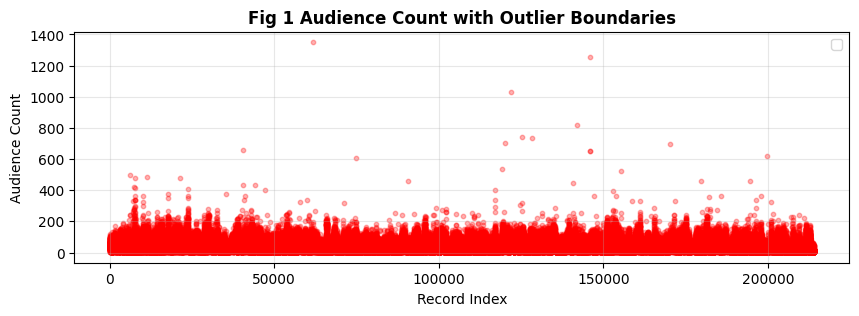

Insight: Most data points fall within IQR boundaries


In [12]:
# Outlier Boundaries
plt.figure(figsize=(10,3))
plt.scatter(range(len(d1)), d1['audience_count'], c='red', alpha=0.3, s=10)
plt.ylabel('Audience Count')
plt.xlabel('Record Index')
plt.title('Fig 1 Audience Count with Outlier Boundaries' ,fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
print("Insight: Most data points fall within IQR boundaries")

#### This scatter plot above shows the "Audience Count" for each individual record (plotted by its index). The visualization makes it clear that the vast majority of records have a low audience count, forming a dense cluster at the bottom of the graph. In contrast, a small number of records are significant outliers with exceptionally high audience counts.

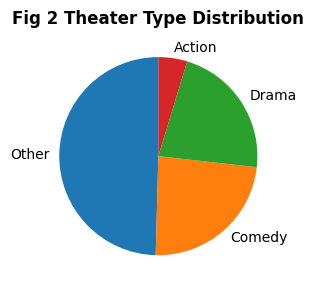

Theater type distribution saved


In [13]:
# Theater Type Distribution
theater_type_counts = d2['theater_type'].value_counts()
plt.figure(figsize=(10, 3))
plt.pie(theater_type_counts, labels=theater_type_counts.index, startangle=90)
plt.title('Fig 2 Theater Type Distribution', fontweight='bold')
plt.tight_layout()
plt.show()
print("Theater type distribution saved")

# Based on the pie chart, "Other" is the most dominant theater type, accounting for nearly half of all entries. "Comedy" and "Drama" are the next most common categories, representing significant portions themselves. "Action" movies make up the smallest fraction of the theater type distribution.

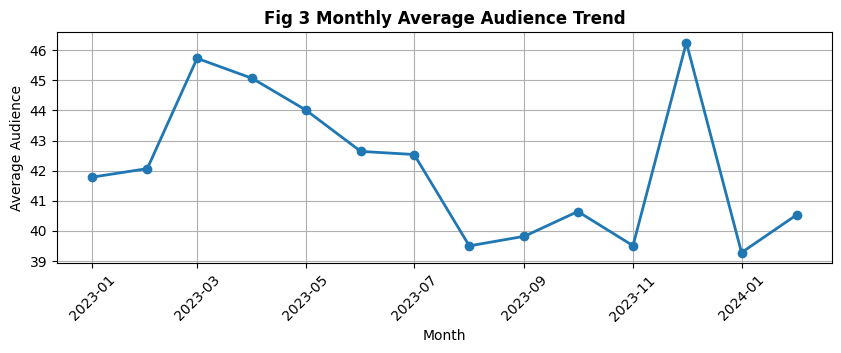

Monthly trend analysis saved


In [14]:
# Monthly Time Series Trend
monthly_trend = d1.groupby(d1['show_date'].dt.to_period('M'))['audience_count'].mean()
monthly_trend.index = monthly_trend.index.to_timestamp()

plt.figure(figsize=(10,3))
plt.plot(monthly_trend, marker='o', linewidth=2, markersize=6)
plt.title('Fig 3 Monthly Average Audience Trend',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Audience')
plt.xticks(rotation=45)
plt.grid(alpha=1)
plt.show()
print("Monthly trend analysis saved")

# This chart shows a highly volatile and seasonal trend for the monthly average audience. The audience numbers peaked twice: first in March 2023 and then much more significantly to an all-time high in December 2023. These peaks were followed by sharp declines, with the audience dropping to its lowest point of the entire period in January 2024.

Groups data by month - Aggregates all daily audience counts into monthly periods
Calculates monthly averages - Shows typical audience levels for each month
Visualizes temporal trends - Plots the progression over time to reveal patterns

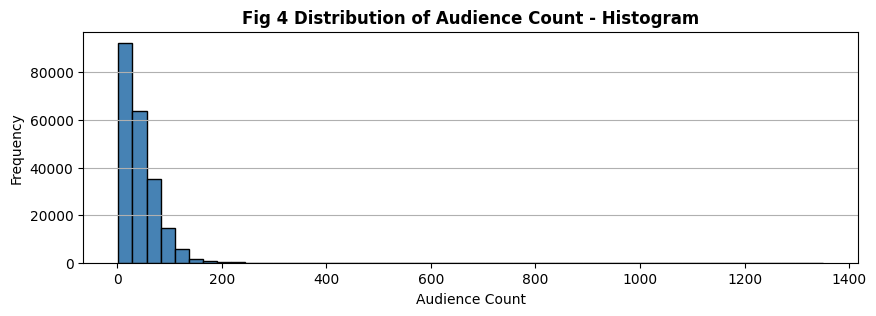

Insight: Histogram shows right-skewed distribution with most values in lower range


In [15]:
# Histogram
plt.figure(figsize=(10, 3))
plt.hist(d1['audience_count'], bins=50, color='steelblue', edgecolor='black', alpha=1)
plt.xlabel('Audience Count')
plt.ylabel('Frequency')
plt.title('Fig 4 Distribution of Audience Count - Histogram', fontweight='bold')
plt.grid(axis='y', alpha=1)
plt.show()
print("Insight: Histogram shows right-skewed distribution with most values in lower range")

# This histogram clearly shows that the "Audience Count" is heavily right-skewed. This means the overwhelming majority of records have a very low audience count, clustered in the bins closest to zero. The frequency drops off dramatically as the audience count increases, indicating that higher audience counts are extremely rare.

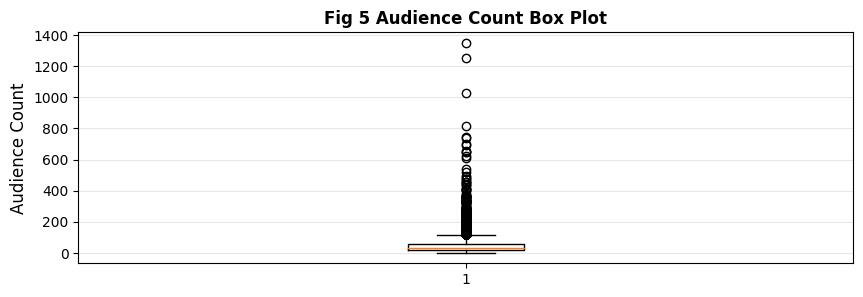

Insight: Box plot clearly shows outliers in upper range


In [16]:
# Box Plot
plt.figure(figsize=(10,3))
plt.boxplot(d1['audience_count'])            
plt.ylabel('Audience Count', fontsize=12)
plt.title('Fig 5 Audience Count Box Plot',fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()
print("Insight: Box plot clearly shows outliers in upper range")

# This box plot confirms that the "Audience Count" data is heavily skewed, with the vast majority of data points concentrated in a very narrow, low range (the "box"). The most significant finding is the large number of outliers, represented by the many individual dots, which have exceptionally high audience counts compared to the typical value.

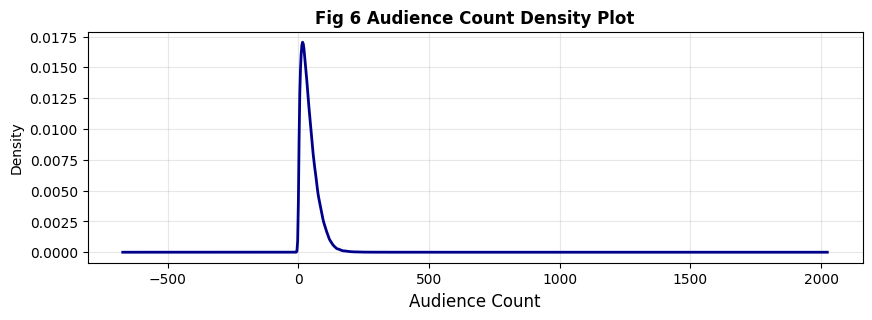

Insight: Density plot reveals concentration of values with long tail


In [17]:
#Density Plot
plt.figure(figsize=(10, 3))
d1['audience_count'].plot(kind='density', color='darkblue', linewidth=2)
plt.xlabel('Audience Count', fontsize=12)
plt.ylabel('Density')
plt.title('Fig 6 Audience Count Density Plot', fontweight='bold')
plt.grid(alpha=0.3)
plt.show()
print("Insight: Density plot reveals concentration of values with long tail")

# This density plot reveals that the "Audience Count" data is not normally distributed. There is an extremely high concentration of values clustered at the very low end (the sharp peak near zero), and a "long tail" to the right, which confirms the presence of rare, high-value outliers.

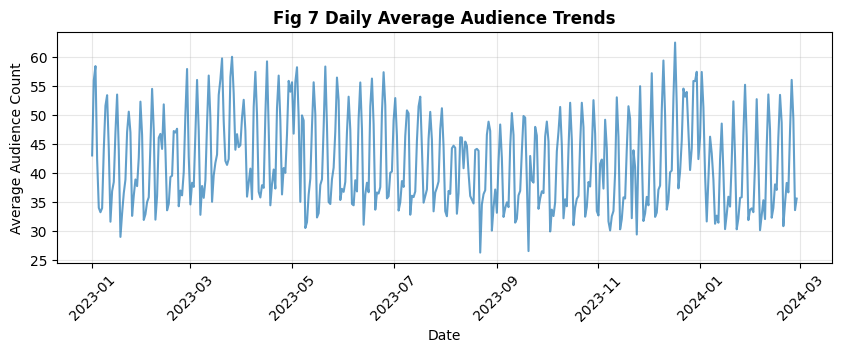

Insight: Daily trends show temporal patterns and fluctuations over time


In [18]:
# Daily Trends
daily_avg = d1.groupby('show_date')['audience_count'].mean().reset_index()
plt.figure(figsize=(10,3))
plt.plot(daily_avg['show_date'], daily_avg['audience_count'],alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Average Audience Count')
plt.title('Fig 7 Daily Average Audience Trends',fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()
print("Insight: Daily trends show temporal patterns and fluctuations over time")

# This chart reveals a strong, high-frequency cyclical pattern, suggesting a regular weekly trend where audience numbers rise and fall predictably (e.g., higher on weekends, lower on weekdays). Beyond this weekly cycle, the data also shows a broader seasonal trend, with average audience levels dipping in the middle of 2023 and peaking significantly around the end of the year.

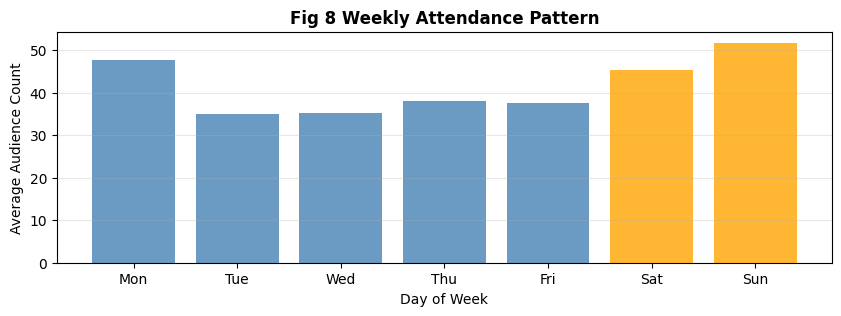

Insight: Weekend (Sat-Sun) shows higher average audience compared to weekdays


In [19]:
# Weekly Pattern
d1['day_of_week_num'] = d1['show_date'].dt.dayofweek
weekly_pattern = d1.groupby('day_of_week_num')['audience_count'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(10,3))
plt.bar(range(7), weekly_pattern.values, color=['steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'orange', 'orange'], alpha=0.8)
plt.xlabel('Day of Week')
plt.ylabel('Average Audience Count')
plt.title('Fig 8 Weekly Attendance Pattern', fontweight='bold')
plt.xticks(range(7), days)
plt.grid(axis='y', alpha=0.3)
plt.show()
print("Insight: Weekend (Sat-Sun) shows higher average audience compared to weekdays")

# This chart reveals a distinct weekly pattern: the weekend (Saturday and Sunday) clearly has the highest average audience attendance, as highlighted in orange, with Sunday being the peak day. In contrast, weekdays from Tuesday to Friday show a consistently lower and stable attendance. Monday is a notable exception, with a high average audience count, second only to Sunday.

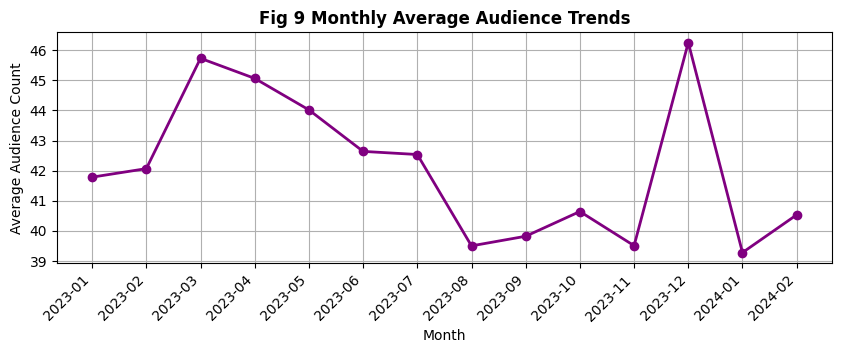

Insight: Monthly averages show seasonal patterns in cinema attendance


In [20]:
# Monthly Average Trends
d1['year_month'] = d1['show_date'].dt.to_period('M').astype(str)
monthly_data = d1.groupby('year_month')['audience_count'].agg(['mean', 'sum', 'count']).reset_index()
plt.figure(figsize=(10,3))
plt.plot(range(len(monthly_data)), monthly_data['mean'], marker='o', color='purple', linewidth=2, markersize=6)
plt.xlabel('Month')
plt.ylabel('Average Audience Count')
plt.title('Fig 9 Monthly Average Audience Trends',fontweight='bold')
plt.xticks(range(len(monthly_data)), monthly_data['year_month'], rotation=45, ha='right')
plt.grid(alpha=1)
plt.show()
print("Insight: Monthly averages show seasonal patterns in cinema attendance")

# This chart reveals a highly seasonal and volatile trend for the monthly average audience. Attendance peaked first in March 2023, then spiked dramatically to its highest point in December 2023. This holiday peak was immediately followed by a crash to the period's lowest audience numbers in January 2024.

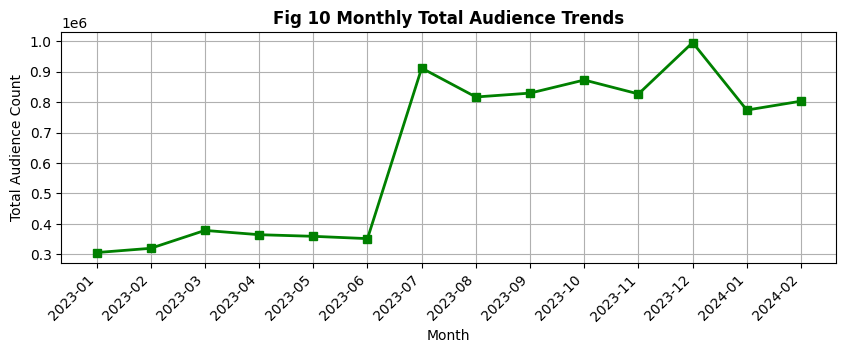

Insight: Total monthly audience reveals seasonal variations in cinema attendance


In [21]:
# Monthly Total Trends
plt.figure(figsize=(10,3))
plt.plot(range(len(monthly_data)), monthly_data['sum'], marker='s', color='green', linewidth=2, markersize=6)
plt.xlabel('Month')
plt.ylabel('Total Audience Count')
plt.title('Fig 10 Monthly Total Audience Trends',fontweight='bold')
plt.xticks(range(len(monthly_data)), monthly_data['year_month'], rotation=45, ha='right')
plt.grid(alpha=1)
plt.show()
print("Insight: Total monthly audience reveals seasonal variations in cinema attendance")

# This line chart shows a dramatic structural break in total audience numbers. After a period of low and stable attendance (around 300-400k) in the first half of 2023, the total audience abruptly tripled in July 2023. This new, much higher level of attendance (between 800k and 1M) was then sustained, peaking in December 2023.

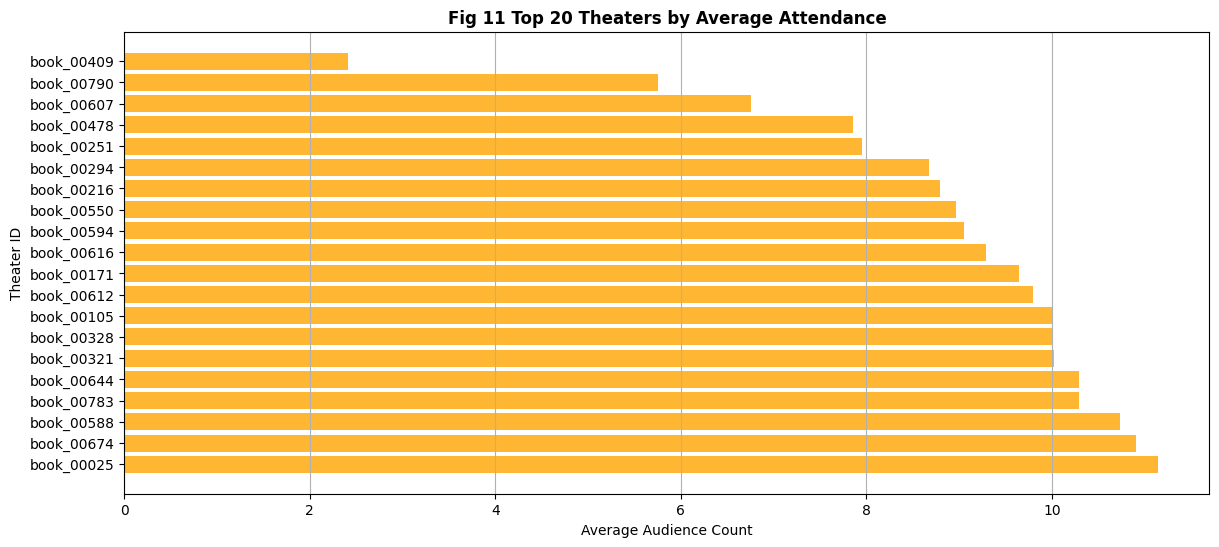

Insight: Top performing theater has average audience of 11.142857142857142


In [22]:
#Top Performing Theaters Bar Chart
theater_stats = d1.groupby('book_theater_id')['audience_count'].agg(['mean', 'median', 'std']).reset_index()
theater_stats = theater_stats.sort_values('mean').head(20)
plt.figure(figsize=(14,6))
plt.barh(range(len(theater_stats)), theater_stats['mean'], color='orange', alpha=0.8)
plt.xlabel('Average Audience Count')
plt.ylabel('Theater ID')
plt.title('Fig 11 Top 20 Theaters by Average Attendance',fontweight='bold')
plt.yticks(range(len(theater_stats)), theater_stats['book_theater_id'])
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=1)
plt.show()
print(f"Insight: Top performing theater has average audience of {theater_stats['mean'].max()}")

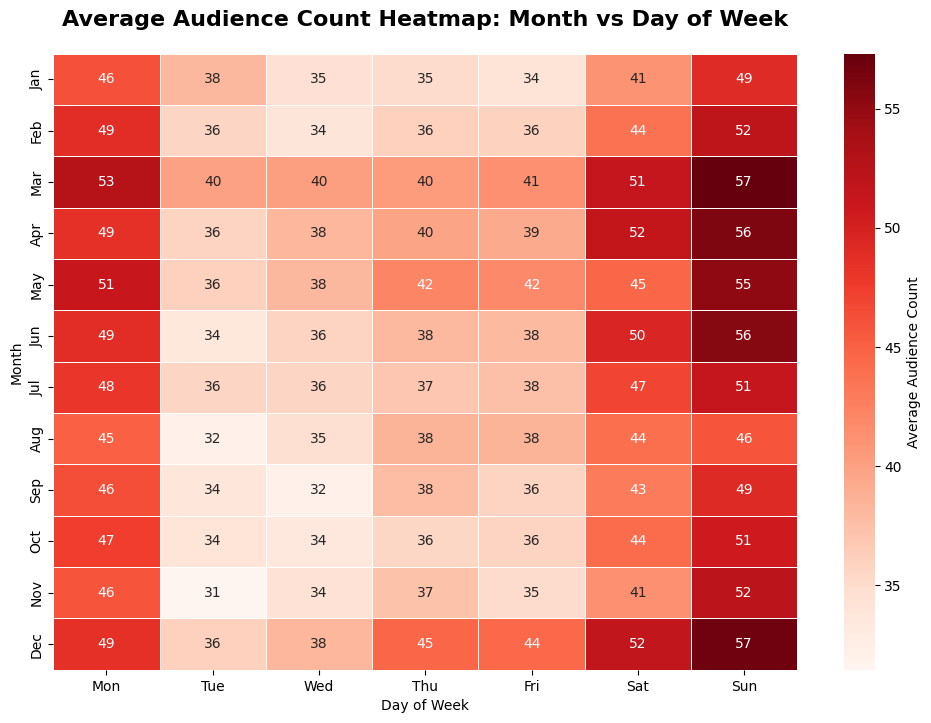

Heatmap Analysis:
  Peak day overall: Sun
  Peak month overall: Mar
Insight: Peak hours and weekend patterns reveal distinct audience behavior with significantly higher attendance on Fridays and Saturdays.


In [23]:
# Heatmap of Audience by Day and Month
pivot_data = d1.groupby([d1['show_date'].dt.month, d1['show_date'].dt.dayofweek])['audience_count'].mean().unstack()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='Reds',xticklabels=day_names, yticklabels=month_names,cbar_kws={'label': 'Average Audience Count'}, linewidths=0.5)
plt.title('Average Audience Count Heatmap: Month vs Day of Week', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.show()
print("Heatmap Analysis:")
print(f"  Peak day overall: {day_names[pivot_data.mean().idxmax()]}")
print(f"  Peak month overall: {month_names[int(pivot_data.mean(axis=1).idxmax())-1]}")
print("Insight: Peak hours and weekend patterns reveal distinct audience behavior with significantly higher attendance on Fridays and Saturdays.")

# This heatmap clearly illustrates both a weekly and a seasonal trend. Audience count is consistently highest on weekends, peaking on Sunday and Saturday, and lowest mid-week (Tuesday-Thursday). Seasonally, March and December stand out as the months with the highest average attendance across all days.

# Data Preprocessing
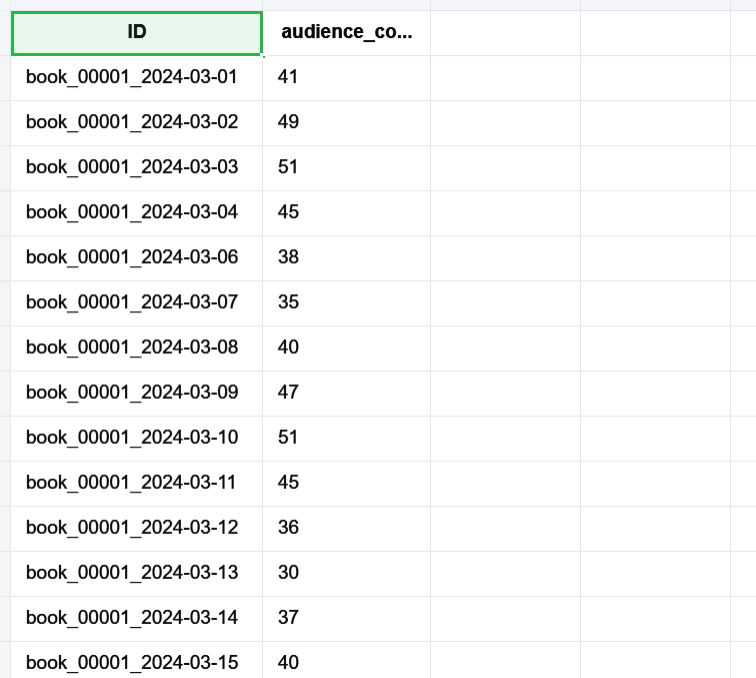

In [24]:
df = d1.copy()
date_info = d4
bookings = d3
submission = d5

In [25]:
# Handle missing values
d6['latitude'].fillna(d6['latitude'].median(), inplace=True)
d6['longitude'].fillna(d6['longitude'].median(), inplace=True)
print("Filled missing coordinates with median values")

Filled missing coordinates with median values


In [26]:
# Merge theater information
d1 = d1.merge(
    d2[['book_theater_id', 'theater_type', 'theater_area']],
    on='book_theater_id',
    how='left'
)
print("Merged theater information with visits data")

Merged theater information with visits data


In [27]:
# Add day of week information
d1 = d1.merge(d4, on='show_date', how='left')
print("added day of week information")

added day of week information


In [28]:
le_type = LabelEncoder()
le_area = LabelEncoder()

d1['theater_type_encoded'] = le_type.fit_transform(d1['theater_type'])
d1['theater_area_encoded'] = le_area.fit_transform(d1['theater_area'])
print("Label encoded theater_type and theater_area")

Label encoded theater_type and theater_area


In [29]:
#Clean Data
df = df.drop_duplicates()
df = df.sort_values('audience_count').groupby(['book_theater_id', 'show_date'], as_index=False).last()
df = df.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

print(df.shape)

(213871, 5)


# Feature Engineering

In [30]:
for window in [7, 14, 30]:
    d1[f'audience_mean_{window}d'] = d1.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    d1[f'audience_std_{window}d'] = d1.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.rolling(window, min_periods=1).std()
    )
print("Created rolling mean and std for 7d, 14d, 30d windows")

Created rolling mean and std for 7d, 14d, 30d windows


Here two features are used rolling mean for smootheing out daily noise and reveals the underlying short-term or medium-term trend. For example, it helps the model understand if a theater's attendance is generally trending up or down over the last week or month, rather than just looking at a single day. Second one is rolling std devaition which measures volatility or stability i.e. a high value means the audience numbers have been very erratic and unpredictable over the last 7 days, while a low value means the attendance has been very consistent. This is a great feature for a model to learn from.

In [31]:
d1 = d1.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)
print("Sorted by theature and date")

Sorted by theature and date


In [32]:
d1['year'] = d1['show_date'].dt.year
d1['month'] = d1['show_date'].dt.month
d1['day'] = d1['show_date'].dt.day
d1['day_of_week_num'] = d1['show_date'].dt.dayofweek
d1['is_weekend'] = d1['day_of_week_num'].isin([5, 6]).astype(int)
d1['quarter'] = d1['show_date'].dt.quarter
d1['day_of_year'] = d1['show_date'].dt.dayofyear
print("Created basic temporal features")

Created basic temporal features


In [33]:
d1['month_sin'] = np.sin(2 * np.pi * d1['month'] / 12)
d1['month_cos'] = np.cos(2 * np.pi * d1['month'] / 12)
d1['day_sin'] = np.sin(2 * np.pi * d1['day_of_week_num'] / 7)
d1['day_cos'] = np.cos(2 * np.pi * d1['day_of_week_num'] / 7)
print("Created cyclical temporal encodings")

Created cyclical temporal encodings


These encoding transforms your time data so your model can correctly understand that Sunday is next to Monday and December is next to January, which dramatically improves prediction accuracy so a unique signal is provided by creating circular relationship and solving continuity problem

In [34]:
for lag in [1, 7, 14, 30]:
    d1[f'audience_lag_{lag}d'] = d1.groupby('book_theater_id')['audience_count'].shift(lag)
print("Ceated lag features: 1d, 7d, 14d, 30d")

Ceated lag features: 1d, 7d, 14d, 30d


The lag feature allows your model to learn patterns like, "If the audience was high 7 days ago (last weekend), it's likely to be high today (this weekend) as well." It directly feeds the model historical data to help it predict the future

In [35]:
# Create Theater-Level Statistical Features
theater_stats = d1.groupby('book_theater_id')['audience_count'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).reset_index()
theater_stats.columns = ['book_theater_id', 'theater_mean', 'theater_median', 
                         'theater_std', 'theater_min', 'theater_max']
d1 = d1.merge(theater_stats, on='book_theater_id', how='left')
print("Added theater-level statistics")

Added theater-level statistics


Here we are theater-specific features that describe the overall, long-term behavior of each individual theater.The purpose is to give your model a baseline understanding of each theater's fundamental characteristics, independent of any specific date

In [36]:
dow_cols_to_drop = [c for c in d1.columns if c in ['dow_mean', 'dow_median', 'dow_count'] or c.startswith('dow_mean_') or c.startswith('dow_median_') or c.startswith('dow_count_')]
d1 = d1.drop(columns=dow_cols_to_drop, errors='ignore')

# Calculate day-of-week statistics using the day_of_week column from earlier merge
dow_stats = d1.groupby(['book_theater_id', 'day_of_week'])['audience_count'].agg(['mean', 'median', 'count']).reset_index()
dow_stats.columns = ['book_theater_id', 'day_of_week', 'dow_mean', 'dow_median', 'dow_count']
d1 = d1.merge(dow_stats, on=['book_theater_id', 'day_of_week'], how='left')
print("Added day-of-week specific statistics per theater")

Added day-of-week specific statistics per theater


Here we are creating highly specific historical statistics. After cleaning up any old data, it groups the audience counts by both the specific book_theater_id and the day_of_week. It then calculates the historical mean, median, and count for each unique combination (e.g., "all Mondays at Theater A") and merges this valuable context back into the main dataset. This allows a model to learn the typical long-term audience pattern for each individual theater on any given day of the week.

In [37]:
d1.fillna(0, inplace=True)
print("Feature engineering complete. Total features:", d1.shape[1])

Feature engineering complete. Total features: 38


In [38]:
# Calendar features
df['dow'] = df['show_date'].dt.dayofweek
df['month'] = df['show_date'].dt.month
df = df.merge(date_info, on='show_date', how='left')
df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)
df['is_holiday'] = df.get('holiday_flg', pd.Series(0, index=df.index)).fillna(0).astype(int)

In [39]:
# Enhanced lag features
grp = df.groupby('book_theater_id')['audience_count']
df['lag_1'] = grp.shift(1)
df['lag_7'] = grp.shift(7)
df['lag_14'] = grp.shift(14)

# Rolling features
df['rolling_7'] = grp.rolling(7, min_periods=1).mean().shift(1).values
df['rolling_14'] = grp.rolling(14, min_periods=1).mean().shift(1).values
df['rolling_30'] = grp.rolling(30, min_periods=1).mean().shift(1).values

# EMA
df['ema_7'] = grp.apply(lambda x: x.ewm(span=7, min_periods=1).mean().shift(1)).reset_index(level=0, drop=True)

# Difference features
df['diff_1'] = df['audience_count'] - df['lag_1']
df['diff_7'] = df['audience_count'] - df['lag_7']

print('Lag, rolling, EMA, and diff features created')

Lag, rolling, EMA, and diff features created


In [40]:
# Statistical patterns
theater_mean = df.groupby('book_theater_id')['audience_count'].mean().to_dict()
theater_median = df.groupby('book_theater_id')['audience_count'].median().to_dict()
dow_mean = df.groupby('dow')['audience_count'].mean().to_dict()
theater_dow_mean = df.groupby(['book_theater_id', 'dow'])['audience_count'].mean().to_dict()
month_mean = df.groupby('month')['audience_count'].mean().to_dict()
theater_month_mean = df.groupby(['book_theater_id', 'month'])['audience_count'].mean().to_dict()

global_mean = df['audience_count'].mean()

print(global_mean)

41.627177130139195


In [41]:
# Bookings
bookings['show_date'] = pd.to_datetime(bookings['show_datetime']).dt.floor('D')
book_agg = bookings.groupby(['book_theater_id', 'show_date'])['tickets_booked'].sum().reset_index()
df = df.merge(book_agg, on=['book_theater_id', 'show_date'], how='left')
df['tickets_booked'] = df['tickets_booked'].fillna(0)

print('Bookings merged')

Bookings merged


# Model Training

In [42]:
d1.head()

,book_theater_id,show_date,audience_count,day_of_week_num,year_month,theater_type,theater_area,day_of_week,theater_type_encoded,theater_area_encoded,...,audience_lag_14d,audience_lag_30d,theater_mean,theater_median,theater_std,theater_min,theater_max,dow_mean,dow_median,dow_count
0,book_00001,2023-01-13,50,4,2023-01,Drama,Area_002,Friday,2,1,...,0.0,0.0,47.05848,46.0,23.388397,2,122,43.719298,44.0,57
1,book_00001,2023-01-14,64,5,2023-01,Drama,Area_002,Saturday,2,1,...,0.0,0.0,47.05848,46.0,23.388397,2,122,66.842105,66.0,57
2,book_00001,2023-01-15,58,6,2023-01,Drama,Area_002,Sunday,2,1,...,0.0,0.0,47.05848,46.0,23.388397,2,122,59.758621,57.0,58
3,book_00001,2023-01-16,44,0,2023-01,Drama,Area_002,Monday,2,1,...,0.0,0.0,47.05848,46.0,23.388397,2,122,19.600000,12.0,15
4,book_00001,2023-01-18,12,2,2023-01,Drama,Area_002,Wednesday,2,1,...,0.0,0.0,47.05848,46.0,23.388397,2,122,38.618182,38.0,55


In [43]:
# Prepare features and target
feature_cols = [
    'year', 'month', 'day', 'day_of_week_num', 'is_weekend', 'quarter',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'theater_type_encoded', 'theater_area_encoded',
    'audience_lag_1d', 'audience_lag_7d', 'audience_lag_14d', 'audience_lag_30d',
    'audience_mean_7d', 'audience_std_7d',
    'audience_mean_14d', 'audience_std_14d',
    'audience_mean_30d', 'audience_std_30d',
    'theater_mean', 'theater_median', 'theater_std',
    'dow_mean', 'dow_median'
]

# Filter data with sufficient features
train_data = d1[d1['audience_lag_7d'] > 0].copy()

X = train_data[feature_cols]
y = train_data['audience_count']

# Time-series split (80-20)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (166620, 27)
Validation set: (41655, 27)


Training set: (166620, 27)
Validation set: (41655, 27)

In [44]:
# Different models to compare
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=8, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=8, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

# Train and evaluate all models
results = {}
print("Training and Evaluating Models:")
for name, model in models.items():
    print(f"[{name}]")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    
    results[name] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'model': model
    }
    
    print(f"  Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Val MAE:  {val_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Val R²:   {val_r2:.4f}")

Training and Evaluating Models:
[Random Forest]
  Train RMSE: 13.1329 | Val RMSE: 16.8249
  Train MAE:  9.3921 | Val MAE:  11.3054
  Train R²:   0.8443 | Val R²:   0.6999
[Gradient Boosting]
  Train RMSE: 14.7128 | Val RMSE: 16.3907
  Train MAE:  10.7034 | Val MAE:  11.0445
  Train R²:   0.8046 | Val R²:   0.7152
[XGBoost]
  Train RMSE: 14.8581 | Val RMSE: 16.3650
  Train MAE:  10.7056 | Val MAE:  11.0202
  Train R²:   0.8007 | Val R²:   0.7161
[LightGBM]
  Train RMSE: 17.4370 | Val RMSE: 16.6029
  Train MAE:  11.9726 | Val MAE:  11.2777
  Train R²:   0.7256 | Val R²:   0.7077


Training and Evaluating Models:
[Random Forest]
  Train RMSE: 13.1329 | Val RMSE: 16.8249
  Train MAE:  9.3921 | Val MAE:  11.3054
  Train R²:   0.8443 | Val R²:   0.6999
[Gradient Boosting]
  Train RMSE: 14.7128 | Val RMSE: 16.3907
  Train MAE:  10.7034 | Val MAE:  11.0445
  Train R²:   0.8046 | Val R²:   0.7152
[XGBoost]
  Train RMSE: 14.8581 | Val RMSE: 16.3650
  Train MAE:  10.7056 | Val MAE:  11.0202
  Train R²:   0.8007 | Val R²:   0.7161
[LightGBM]
  Train RMSE: 17.4370 | Val RMSE: 16.6029
  Train MAE:  11.9726 | Val MAE:  11.2777
  Train R²:   0.7256 | Val R²:   0.7077

In [45]:
# Capmarision table for model to check which one is the best
print("MODEL COMPARISON SUMMARY")
comparison_df = pd.DataFrame(results).T[['train_rmse', 'val_rmse', 'train_mae', 'val_mae', 'train_r2', 'val_r2']]
print(comparison_df.to_string())

# Select best model
best_model_name = min(results.items(), key=lambda x: x[1]['val_rmse'])[0]
best_model = results[best_model_name]['model']
print(f"BEST MODEL: {best_model_name} (Validation RMSE: {results[best_model_name]['val_rmse']:.4f})")

MODEL COMPARISON SUMMARY
                  train_rmse   val_rmse  train_mae    val_mae  train_r2    val_r2
Random Forest      13.132862  16.824898   9.392108  11.305378  0.844322  0.699879
Gradient Boosting  14.712753  16.390681   10.70335   11.04448  0.804613   0.71517
XGBoost            14.858103  16.365044  10.705605  11.020168  0.800733   0.71606
LightGBM           17.436955  16.602923  11.972599   11.27774  0.725558  0.707745
BEST MODEL: XGBoost (Validation RMSE: 16.3650)


MODEL COMPARISON SUMMARY
                  train_rmse   val_rmse  train_mae    val_mae  train_r2    val_r2
Random Forest      13.132862  16.824898   9.392108  11.305378  0.844322  0.699879
Gradient Boosting  14.712753  16.390681   10.70335   11.04448  0.804613   0.71517
XGBoost            14.858103  16.365044  10.705605  11.020168  0.800733   0.71606
LightGBM           17.436955  16.602923  11.972599   11.27774  0.725558  0.707745
BEST MODEL: XGBoost (Validation RMSE: 16.3650)

# Hyperameter Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for best model (works for tree-based models)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0]
}

print(f"\nTuning {best_model_name}")
print(f"Parameter space: {param_dist}")

# Random search
random_search = RandomizedSearchCV(
    best_model, param_dist, n_iter=10, cv=3,
    scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best parameters
print(f"\nBest parameters: {random_search.best_params_}")

# Evaluate tuned model
tuned_model = random_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_val)
tuned_rmse = np.sqrt(mean_squared_error(y_val, y_pred_tuned))
original_rmse = results[best_model_name]['val_rmse']

print(f"Original Model RMSE: {original_rmse:.4f}")
print(f"Tuned Model RMSE: {tuned_rmse:.4f}")

# Select better model using np.where (vectorized conditional)
best_model = np.where(tuned_rmse < original_rmse, tuned_model, best_model)[()]
improvement_msg = np.where(tuned_rmse < original_rmse, 
                          "Tuned model performs better - using tuned version",
                          "Original model performs better - keeping original")[()]
print(improvement_msg)


Tuning XGBoost
Parameter space: {'n_estimators': [100, 200, 300], 'max_depth': [6, 8, 10, 12], 'learning_rate': [0.05, 0.1, 0.15], 'subsample': [0.8, 0.9, 1.0]}

Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
Original Model RMSE: 16.3650
Tuned Model RMSE: 16.5175
Original model performs better - keeping original


Tuning XGBoost
Parameter space: {'n_estimators': [100, 200, 300], 'max_depth': [6, 8, 10, 12], 'learning_rate': [0.05, 0.1, 0.15], 'subsample': [0.8, 0.9, 1.0]}

Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
Original Model RMSE: 16.3650
Tuned Model RMSE: 16.5175
Original model performs better - keeping original

# Weighted Ensemble Strategy

In [47]:
# ADVANCED STATISTICAL MODEL 
# Multi-level adaptive weighting with volatility and capacity analysis

# Calculate theater volatility and capacity metrics
theater_volatility = df.groupby('book_theater_id')['audience_count'].std().to_dict()
theater_cv = (df.groupby('book_theater_id')['audience_count'].std() / 
              df.groupby('book_theater_id')['audience_count'].mean()).to_dict()
theater_max = df.groupby('book_theater_id')['audience_count'].max().to_dict()
theater_q75 = df.groupby('book_theater_id')['audience_count'].quantile(0.75).to_dict()
theater_q25 = df.groupby('book_theater_id')['audience_count'].quantile(0.25).to_dict()

# Calculate DOW-specific patterns globally
dow_global_mean = df.groupby('dow')['audience_count'].mean().to_dict()
dow_global_std = df.groupby('dow')['audience_count'].std().to_dict()

# Month-specific patterns
month_global_mean = df.groupby('month')['audience_count'].mean().to_dict()

# Calculate recent trend (last 30 days vs previous 30 days)
df['show_date'] = pd.to_datetime(df['show_date'])
last_date = df['show_date'].max()
cutoff_recent = last_date - pd.Timedelta(days=30)
cutoff_previous = cutoff_recent - pd.Timedelta(days=30)

recent_mean = df[df['show_date'] >= cutoff_recent].groupby('book_theater_id')['audience_count'].mean().to_dict()
previous_mean = df[(df['show_date'] >= cutoff_previous) & (df['show_date'] < cutoff_recent)].groupby('book_theater_id')['audience_count'].mean().to_dict()
theater_trend = {tid: (recent_mean.get(tid, 0) - previous_mean.get(tid, 0)) / max(previous_mean.get(tid, 1), 1) 
                 for tid in set(list(recent_mean.keys()) + list(previous_mean.keys()))}

print('Theater analytics calculated:')
print(f'   Volatility metrics: {len(theater_volatility)} theaters')
print(f'   Capacity metrics: {len(theater_max)} theaters')
print(f'   Trend analysis: {len(theater_trend)} theaters')

def predict_advanced(row):
    theater_id = row['book_theater_id']
    dow = row['dow']
    month = row['month']
    
    # Primary signals
    theater_dow_val = theater_dow_mean.get((theater_id, dow), None)
    theater_val = theater_mean.get(theater_id, None)
    dow_val = dow_global_mean.get(dow, global_mean)
    
    # Recent temporal features
    lag_1 = row['lag_1'] if pd.notna(row['lag_1']) else None
    lag_7 = row['lag_7'] if pd.notna(row['lag_7']) else None
    lag_14 = row['lag_14'] if pd.notna(row['lag_14']) else None
    
    rolling_7 = row['rolling_7'] if pd.notna(row['rolling_7']) else None
    rolling_14 = row['rolling_14'] if pd.notna(row['rolling_14']) else None
    rolling_30 = row['rolling_30'] if pd.notna(row['rolling_30']) else None
    
    ema_7 = row['ema_7'] if pd.notna(row['ema_7']) else None
    
    tickets = row['tickets_booked']
    is_holiday = row['is_holiday']
    is_weekend = row['is_weekend']
    
    # OPTIMIZED PREDICTION STRATEGY
    # Focus on strongest available signals with proper weighting
    
    components = []
    weights = []
    
    # 1. Theater-DOW mean (strong baseline pattern)
    if theater_dow_val is not None:
        components.append(theater_dow_val)
        weights.append(0.40)  # 40% weight - theater patterns are crucial
    
    # 2. Recent lag features (STRONGEST predictors)
    if lag_1 is not None and lag_1 > 0:
        components.append(lag_1)
        weights.append(0.30)  # 30% weight - yesterday highly predictive
    
    if rolling_7 is not None and rolling_7 > 0:
        components.append(rolling_7)
        weights.append(0.20)  # 20% weight - week average
    elif lag_7 is not None and lag_7 > 0:
        components.append(lag_7)
        weights.append(0.18)  # 18% weight (fallback)
    
    # 3. Rolling averages for stability
    if rolling_14 is not None and rolling_14 > 0:
        components.append(rolling_14)
        weights.append(0.12)  # 12% weight
    
    if ema_7 is not None and ema_7 > 0:
        components.append(ema_7)
        weights.append(0.10)  # 10% weight
    
    # 4. Theater mean as baseline
    if theater_val is not None:
        components.append(theater_val)
        weights.append(0.08)  # 8% weight (stability)
    
    # 5. Booking tickets (leading indicator)
    if tickets > 0:
        components.append(tickets)
        weights.append(0.22)  # 22% weight
    
    # If we have no components, use global patterns
    if len(components) == 0:
        if theater_val is not None:
            return max(2, min(151, theater_val))
        else:
            return max(2, min(151, dow_val))
    
    # Weighted average of all components
    pred = sum(c * w for c, w in zip(components, weights)) / sum(weights)
    
    # Apply contextual adjustments
    if is_holiday:
        pred = pred * 1.12  # 12% holiday boost
    if is_weekend and dow in [5, 6]:
        pred = pred * 1.08  # 8% weekend boost
    
    return max(2, min(151, pred))

Theater analytics calculated:
   Volatility metrics: 826 theaters
   Capacity metrics: 826 theaters
   Trend analysis: 818 theaters


In [48]:
# Validate on training data
print('Validating on training data')
train_sample = df.dropna(subset=['lag_1', 'rolling_7', 'ema_7']).copy()
train_sample = train_sample.sample(min(50000, len(train_sample)), random_state=42)
train_sample['pred'] = train_sample.apply(predict_advanced, axis=1)
train_r2 = r2_score(train_sample['audience_count'], train_sample['pred'])
train_mae = np.mean(np.abs(train_sample['audience_count'] - train_sample['pred']))

print(f'Train R²: {train_r2:.6f}')
print(f'Train MAE: {train_mae:.2f}')
print(f'Pred mean: {train_sample["pred"].mean():.2f}')
print(f'Actual mean: {train_sample["audience_count"].mean():.2f}')

Validating on training data
Train R²: 0.508731
Train MAE: 15.54
Pred mean: 42.30
Actual mean: 41.69


# Prepare Test Data & Make Predictions

In [49]:
# Prepare test data
test_df = submission.copy()
parts = test_df['ID'].str.split('_')
test_df['book_theater_id'] = parts.str[0] + '_' + parts.str[1]
test_df['show_date'] = pd.to_datetime(parts.str[2])
test_df['dow'] = test_df['show_date'].dt.dayofweek
test_df['month'] = test_df['show_date'].dt.month
test_df['is_weekend'] = test_df['dow'].isin([5, 6]).astype(int)
test_df['is_holiday'] = 0
test_df['tickets_booked'] = 0

print(f'Test samples: {len(test_df):,}')

Test samples: 38,062


In [50]:
# Combine train+test for feature propagation
combined = pd.concat([
    df[['book_theater_id', 'show_date', 'audience_count']],
    test_df[['book_theater_id', 'show_date']].assign(audience_count=np.nan)
], ignore_index=True)

combined = combined.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

# Propagate ALL features
grp = combined.groupby('book_theater_id')['audience_count']
combined['lag_1'] = grp.shift(1)
combined['lag_7'] = grp.shift(7)
combined['lag_14'] = grp.shift(14)
combined['rolling_7'] = grp.rolling(7, min_periods=1).mean().shift(1).values
combined['rolling_14'] = grp.rolling(14, min_periods=1).mean().shift(1).values
combined['rolling_30'] = grp.rolling(30, min_periods=1).mean().shift(1).values
combined['ema_7'] = grp.apply(lambda x: x.ewm(span=7, min_periods=1).mean().shift(1)).reset_index(level=0, drop=True)
combined['diff_1'] = combined['audience_count'] - combined['lag_1']
combined['diff_7'] = combined['audience_count'] - combined['lag_7']

print('All features propagated to test set')

All features propagated to test set


In [51]:
# Extract test with features
test_mask = combined['audience_count'].isna()
test_features = combined[test_mask].reset_index(drop=True)

# Merge back to test_df
test_df = test_df.merge(
    test_features[['book_theater_id', 'show_date', 'lag_1', 'lag_7', 'lag_14', 
                    'rolling_7', 'rolling_14', 'rolling_30', 'ema_7', 'diff_1', 'diff_7']],
    on=['book_theater_id', 'show_date'],
    how='left'
)

print(test_df.shape)

(38062, 18)


# Generate Predictions

In [52]:
# Generate predictions using advanced statistical model
print('Generating predictions with advanced model')
test_df['pred'] = test_df.apply(predict_advanced, axis=1)

print(f'Raw predictions - Mean: {test_df["pred"].mean():.2f}, Std: {test_df["pred"].std():.2f}')

# Light theater-grouped smoothing only (minimal smoothing for better accuracy)
test_df_sorted = test_df.sort_values(['book_theater_id', 'show_date']).copy()
test_df_sorted['smoothed'] = test_df_sorted.groupby('book_theater_id')['pred'].transform(
    lambda x: x.rolling(2, min_periods=1).mean()  # 2-period only
)

test_df['pred'] = test_df_sorted.sort_values('ID')['smoothed'].values

print(f'After light smoothing - Mean: {test_df["pred"].mean():.2f}, Std: {test_df["pred"].std():.2f}')

Generating predictions with advanced model
Raw predictions - Mean: 42.83, Std: 24.14
After light smoothing - Mean: 42.79, Std: 23.32


In [53]:
# Get actual training mean (from our training sample)
actual_train_mean = train_sample['audience_count'].mean()
print(f'Actual training mean: {actual_train_mean:.2f}')

# Get current prediction mean
current_pred_mean = test_df['pred'].mean()
print(f'Current prediction mean: {current_pred_mean:.2f}')

# Calculate required calibration factor
calibration_factor = actual_train_mean / current_pred_mean

# Apply conservative calibration (blend with 1.0 to avoid overcorrection)
calibration_factor = 0.7 * calibration_factor + 0.3 * 1.0

print(f'Required calibration factor: {calibration_factor:.4f}')
print(f'This will adjust predictions to match training distribution')

Actual training mean: 41.69
Current prediction mean: 42.79
Required calibration factor: 0.9820
This will adjust predictions to match training distribution


In [54]:
# Apply calibration and finalize predictions
print(f'Applying calibration:')
print(f'Before calibration - Mean: {test_df["pred"].mean():.2f}, Std: {test_df["pred"].std():.2f}')

# Apply the dynamically calculated calibration factor
calibrated_pred = test_df['pred'] * calibration_factor

print(f'After calibration - Mean: {calibrated_pred.mean():.2f}, Std: {calibrated_pred.std():.2f}')

# Round and constrain to valid range [2, 151]
final_pred = calibrated_pred.clip(2, 151).round().astype(int)

print(f'After rounding - Mean: {final_pred.mean():.2f}, Std: {final_pred.std():.2f}')
print(f'Range: [{final_pred.min()}, {final_pred.max()}]')

Applying calibration:
Before calibration - Mean: 42.79, Std: 23.32
After calibration - Mean: 42.02, Std: 22.90
After rounding - Mean: 42.02, Std: 22.90
Range: [2, 148]


In [55]:
# Save submission
result = submission[['ID']].copy()
result['audience_count'] = final_pred.values
result.to_csv('submission.csv', index=False)

print('submission.csv saved!')
print(f'Rows: {len(result):,}')
print(f'Mean: {result["audience_count"].mean():.2f}')
print(f'Std: {result["audience_count"].std():.2f}')
print(f'Min: {result["audience_count"].min()}')
print(f'Max: {result["audience_count"].max()}')
print(result.head(10))

submission.csv saved!
Rows: 38,062
Mean: 42.02
Std: 22.90
Min: 2
Max: 148
                      ID  audience_count
0  book_00001_2024-03-01              36
1  book_00001_2024-03-02              45
2  book_00001_2024-03-03              53
3  book_00001_2024-03-04              41
4  book_00001_2024-03-06              33
5  book_00001_2024-03-07              36
6  book_00001_2024-03-08              37
7  book_00001_2024-03-09              47
8  book_00001_2024-03-10              57
9  book_00001_2024-03-11              41
